<a href="https://colab.research.google.com/github/mitcheljimenez/pattern-recog/blob/main/Tarea_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import imutils
import re

from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# K Nearest Neighbors

In [3]:
# STEP 1: Get pathnames
def match_substring(arr, substr):
    """
    Matches a substring inside an array of strings.
    
    Args:
        arr (list): An array of strings.
        substr (str): The substring to match.
    
    Returns:
        string (str): The first string that contains the substring.
        None: if no string that contains the substring is found in arr
    """
    for string in arr:
        if substr in string:
            return string
    return None

def list_filenames(directory, contains):
  """
  Lists files in directory that contains a particular substring in filename

  Args:
    directory (str): The directory path.
    substr (str): The substring to match on filenames.
    
  Returns:
    list: A list of strings that contain the substring.
  """
  return [f for f in listdir(directory) if contains in f]

drive_directory = "/content/drive/MyDrive/Reconocimiento de patrones/YaleB"
yale_sub_directory_prefix = "/yaleB"
list_of_most_frontal_angles = ["-005E-10", "-005E+10", "+005E-10", "+005E+10", "+000E+00", "+000E+20", "+000E-20"]

sub_folder_paths_array = []

# Create sub folders pathnames array
for number in range(11, 40):
  if number == 14: continue # Subfolder yaleB14 does not exist
  sub_folder_paths_array.append(drive_directory + yale_sub_directory_prefix + str(number))

# Create arrays of training and testing image pathnames
training_image_pathnames = []
testing_image_pathnames = []
for sub_folder_pathname in sub_folder_paths_array:
  filenames = list_filenames(sub_folder_pathname, "P00A")
  full_path_filenames = [sub_folder_pathname + "/" + filename for filename in filenames]
  training_image_pathnames = training_image_pathnames + [filename for filename in full_path_filenames 
                                                       if any(substring in filename for substring in list_of_most_frontal_angles 
                                                              if isinstance(substring, str))]
  testing_image_pathnames = testing_image_pathnames + [filename for filename in full_path_filenames 
                                                       if not any(substring in filename for substring in list_of_most_frontal_angles 
                                                              if isinstance(substring, str))]

In [4]:
def image_to_feature_vector(image):
  """
  Resizes the image to a fixed size and flattens the image into
	a list of raw pixel intensities.

  Args.
    image (matrix): The image to convert to feature vector.
    size (tuple): The wanted image resized
  
  Returns:
    Image feature vector resized and flattened
  """
  # return cv.resize(image, size).flatten()
  return cv.resize(image, (64,64)).flatten()

# Read training images and process them alongisde their training_labels
training_images = []
training_raw_pixels_images = []
training_labels = []
for image_pathname in training_image_pathnames:
  img = cv.imread(image_pathname)
  _index = image_pathname.find('_')
  label = image_pathname[_index - 2] + image_pathname[_index - 1]

  raw_pixels_img = image_to_feature_vector(img)
  
  training_images.append(img)
  training_raw_pixels_images.append(raw_pixels_img)
  training_labels.append(label)

# Read testing images and process them alongside their testing_labels
testing_images = []
testing_raw_pixels_images = []
testing_labels = []
for image_pathname in testing_image_pathnames:
  img = cv.imread(image_pathname)
  _index = image_pathname.find('_')
  label = image_pathname[_index - 2] + image_pathname[_index - 1]

  raw_pixels_img = image_to_feature_vector(img)
  
  testing_images.append(img)
  testing_raw_pixels_images.append(raw_pixels_img)
  testing_labels.append(label)

# Transform to np.array
training_images = np.array(training_images)
training_raw_pixels_images = np.array(training_raw_pixels_images)
training_labels = np.array(training_labels)

testing_images = np.array(testing_images)
testing_raw_pixels_images = np.array(testing_raw_pixels_images)
testing_labels = np.array(testing_labels)

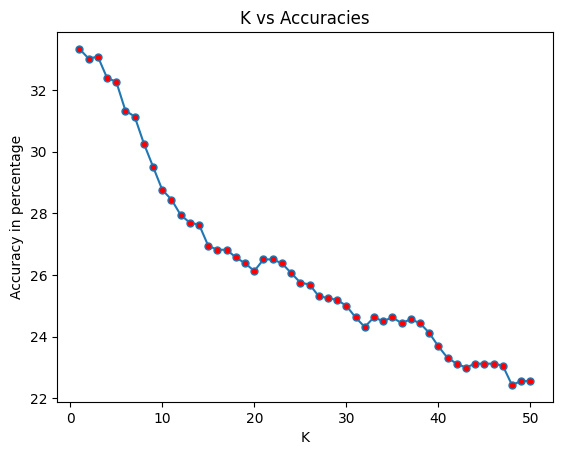

In [5]:
# STEP 3: Find best K
ks = list(range(1, 51))
accuracies = []
for k in ks:
  model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  model.fit(training_raw_pixels_images, training_labels)
  accuracies.append(model.score(testing_raw_pixels_images, testing_labels) * 100)

# Calculate better k
accuracies = np.array(accuracies)
better_k = ks[np.argmax(accuracies)]

# Plot
plt.plot(ks, accuracies, marker="o", markersize=5, markerfacecolor='red')
plt.title('K vs Accuracies')
plt.xlabel('K')
plt.ylabel('Accuracy in percentage')
plt.show()

In [6]:
# STEP 4: Construct test sets by illumination angle and test the model!
def group_pathnames_by_illumination_angles(strings):
  """
  Groups strings based on numbers around 'A' and 'E' characters in the 
  filenames.
  
  Args:
    strings (list): A list of strings representing file paths.
  
  Returns:
    tuple: A tuple with first dictionary with common numbers as keys and matched 
    strings as values and second dictionary with common numbers as keys and
    corresponding person number ID as values.
  """
  pattern = r'yaleB(\d+)_P00A([\d\-]+E[\d\-]+)\.pgm'
  grouped_strings_by_angles = {}
  grouped_strings_by_labels = {}
  for string in strings:
    match = re.search(pattern, string)
    if match:
      person_number = match.group(1)
      pose_numbers = match.group(2)
      key = pose_numbers
      grouped_strings_by_angles.setdefault(key, []).append(string)
      grouped_strings_by_labels.setdefault(key, []).append(person_number)

  return grouped_strings_by_angles, grouped_strings_by_labels

pathnames_dictionary_with_angles, pathnames_dictionary_labels = group_pathnames_by_illumination_angles(testing_image_pathnames)

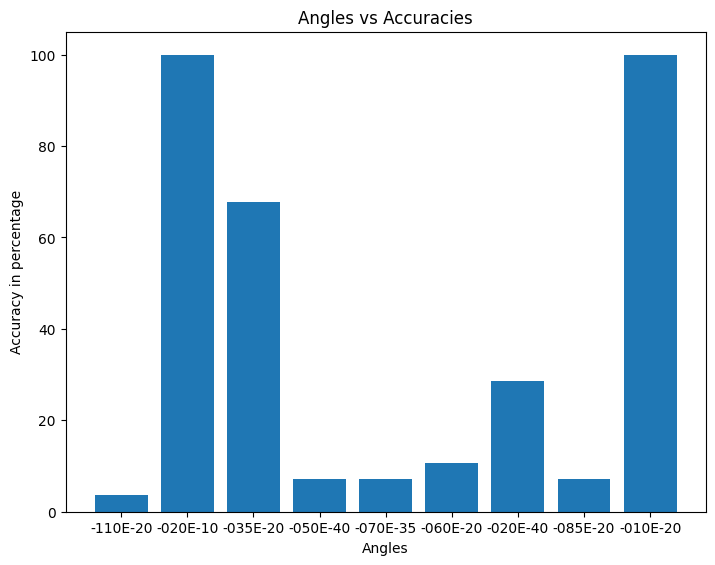

In [7]:
# Create model
model = KNeighborsClassifier(n_neighbors=better_k, n_jobs=-1)
model.fit(training_raw_pixels_images, training_labels)

# Look for scoring metrics
accuracies = []
angles = pathnames_dictionary_with_angles.keys()
for angle in angles:
  pathnames = pathnames_dictionary_with_angles[angle]
  labels = pathnames_dictionary_labels[angle]

  raw_pixels_images = []
  for image_pathname in pathnames:
    img = cv.imread(image_pathname)
    raw_pixels_img = image_to_feature_vector(img)
    raw_pixels_images.append(raw_pixels_img)

  acc = model.score(raw_pixels_images, labels) * 100
  accuracies.append(acc)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(angles, accuracies)
plt.title("Angles vs Accuracies")
plt.xlabel("Angles")
plt.ylabel("Accuracy in percentage")
plt.show()

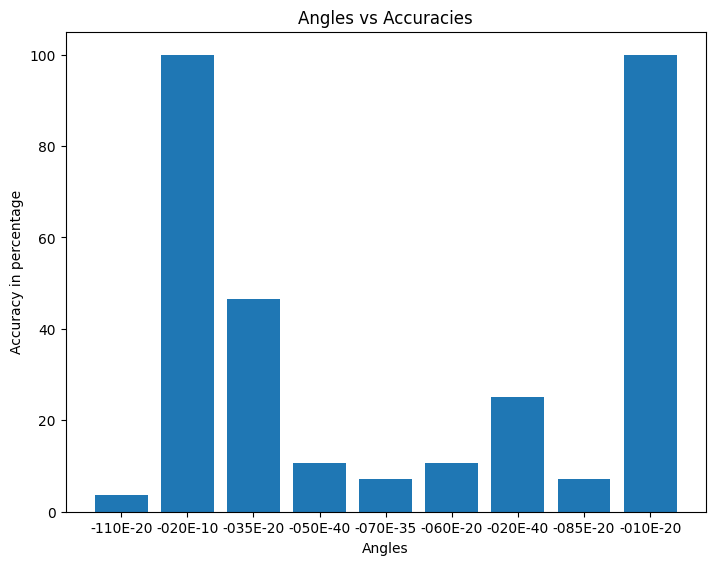

In [8]:
# What if we normalize training data?
min_max_scaler = MinMaxScaler()
normalized_training_raw_pixels = min_max_scaler.fit_transform(training_raw_pixels_images)

model = KNeighborsClassifier(n_neighbors=better_k, n_jobs=-1)
model.fit(normalized_training_raw_pixels, training_labels)

# Look for scoring metrics
accuracies = []
angles = pathnames_dictionary_with_angles.keys()
for angle in angles:
  pathnames = pathnames_dictionary_with_angles[angle]
  labels = pathnames_dictionary_labels[angle]

  raw_pixels_images = []
  for image_pathname in pathnames:
    img = cv.imread(image_pathname)
    raw_pixels_img = image_to_feature_vector(img)
    raw_pixels_images.append(raw_pixels_img)
  
  normalized_testing_raw_pixels = min_max_scaler.transform(raw_pixels_images)

  acc = model.score(normalized_testing_raw_pixels, labels) * 100
  accuracies.append(acc)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(angles, accuracies)
plt.title("Angles vs Accuracies")
plt.xlabel("Angles")
plt.ylabel("Accuracy in percentage")
plt.show()

Well, it didn't help at all!

No mejoró nada.


# PCA

In [9]:
def myPCA(M, k):
  """
  Performs PCA using SVD method.

  Args:
    M (matrix): with training feature vectors 
    k (int): number of eigenvectors, eigenvalues

  Returns:
    A tuple with k eigenvectors and the mean image.
  """
  means = np.mean(M, axis = 0)
  X_centered = M - means
    
  U, s, Vt = np.linalg.svd(X_centered)

  return means, Vt[:k].T

# Usando la función
mean_image, V_eigenvectors = myPCA(training_raw_pixels_images, 10)

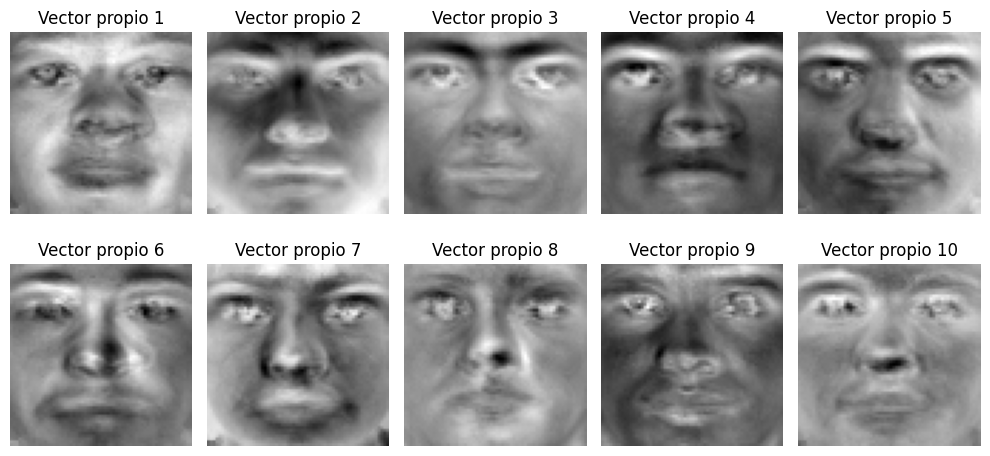

In [10]:
# Re-ordenar los 10 primeros vectores propios como imágenes
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    vector_scaled = (V_eigenvectors[:,i] - V_eigenvectors[:,i].min()) / (V_eigenvectors[:,i].max() - V_eigenvectors[:,i].min())
    image = np.reshape(vector_scaled, (64,64,3))
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Vector propio {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

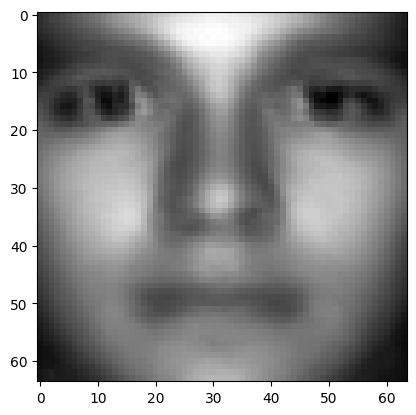

In [11]:
# Mostramos la imagen promedio
mean_image_reshaped = np.reshape(mean_image, (64,64,3))
mean_image_normalized = (mean_image_reshaped - mean_image_reshaped.min()) / (mean_image_reshaped.max() - mean_image_reshaped.min())

plt.imshow(mean_image_normalized)
plt.show()

In [12]:
def getProjection(I, V, means, k):
  """
  Projects I to V.

  Args:
    I (matrix): matrix to project
    V (matrix): eigenvectors matrix in columns
    means (matrix): mean matrix
    k (number): number of k eigenvectors

  Returns:
    X_reduced (matrix): image that was projected
  """
  projection = (I - means) @ V[:, :k]
    
  return projection

# Proyectar 5 caras con k = 3

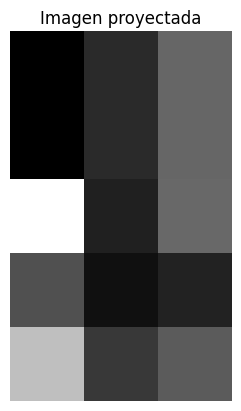

In [13]:
random_image_indices = np.random.randint(0, 27, 5)
images = training_raw_pixels_images[random_image_indices]

projections = []
for image in images:
  projections.append(getProjection(image, V_eigenvectors, mean_image, 3))
  
projections = np.array(projections)
image = (projections - projections.min()) / (projections.max() - projections.min())
plt.imshow(image, cmap='gray')
plt.title("Imagen proyectada")
plt.axis('off')
plt.show()

# Test KNN con PCA

In [14]:
# Create dictionary of raw pixels images
testing_raw_pixel_images_dictionary = {}
angles = pathnames_dictionary_with_angles.keys()
for angle in angles:
  pathnames = pathnames_dictionary_with_angles[angle]

  raw_pixels_images = []
  for image_pathname in pathnames:
    img = cv.imread(image_pathname)
    raw_pixels_img = image_to_feature_vector(img)
    raw_pixels_images.append(raw_pixels_img)

  testing_raw_pixel_images_dictionary.update({ angle: raw_pixels_images})

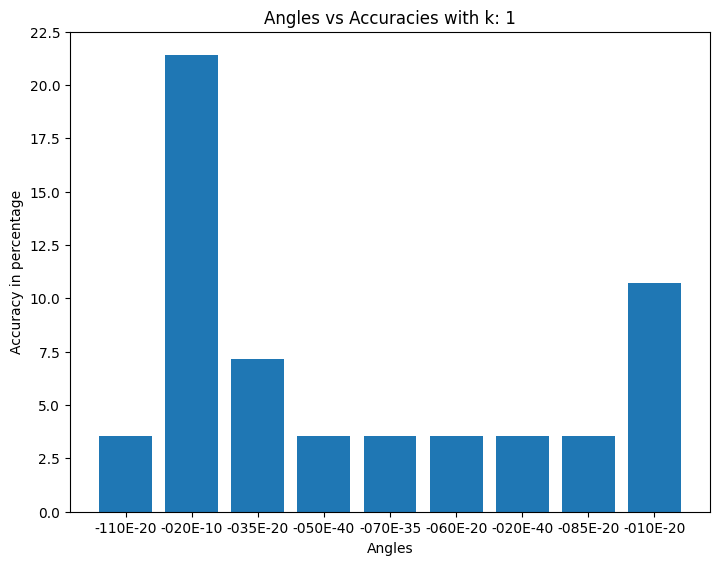

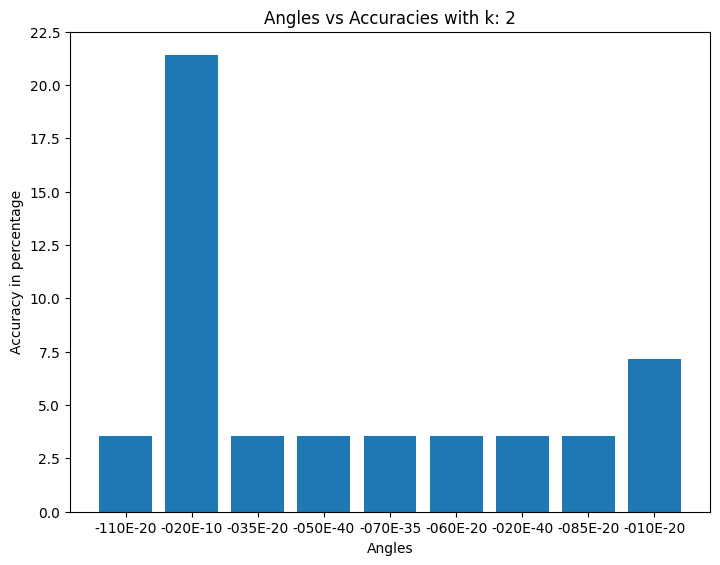

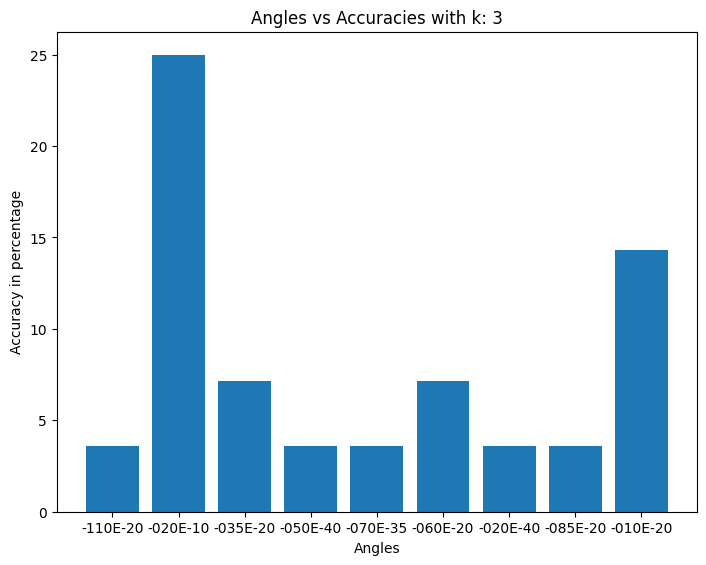

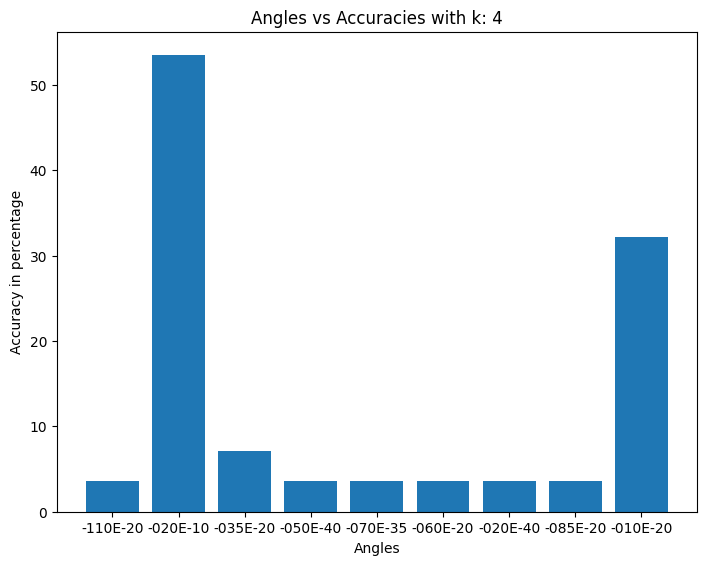

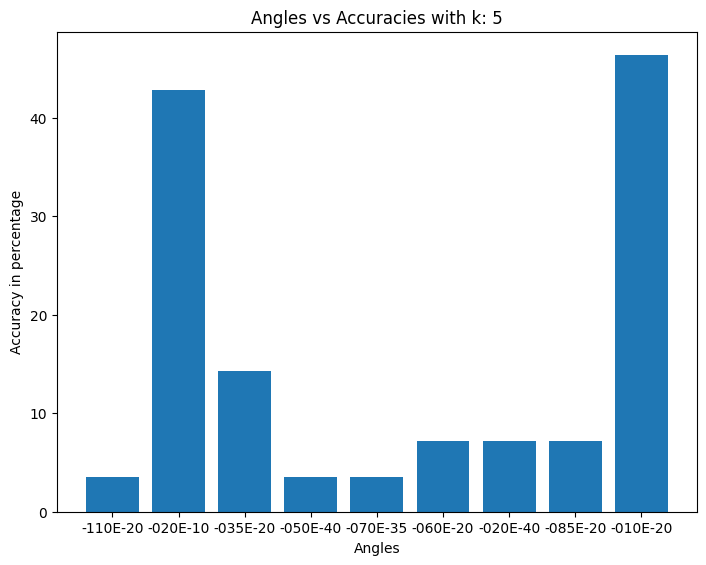

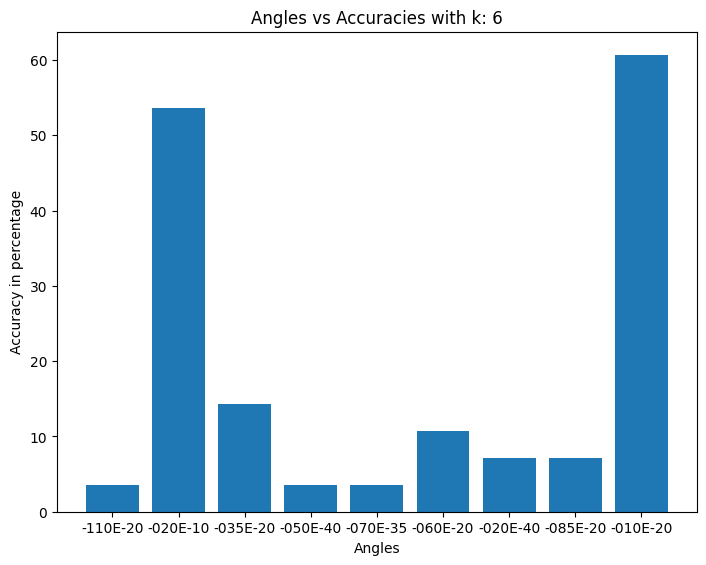

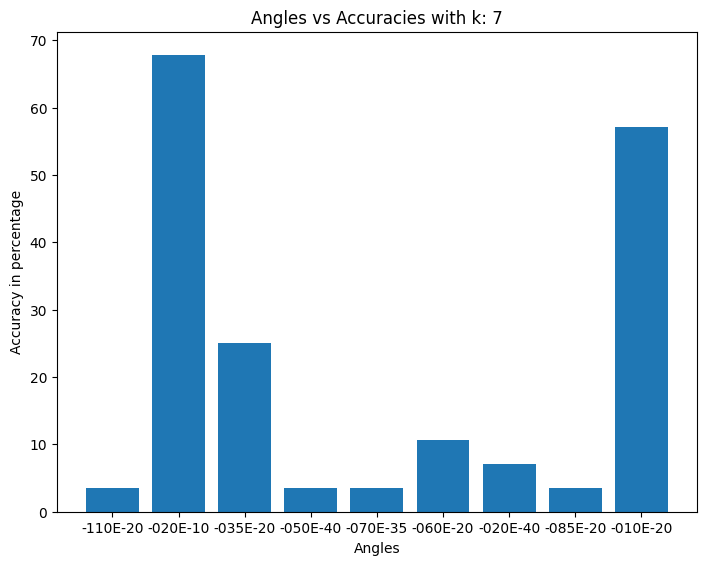

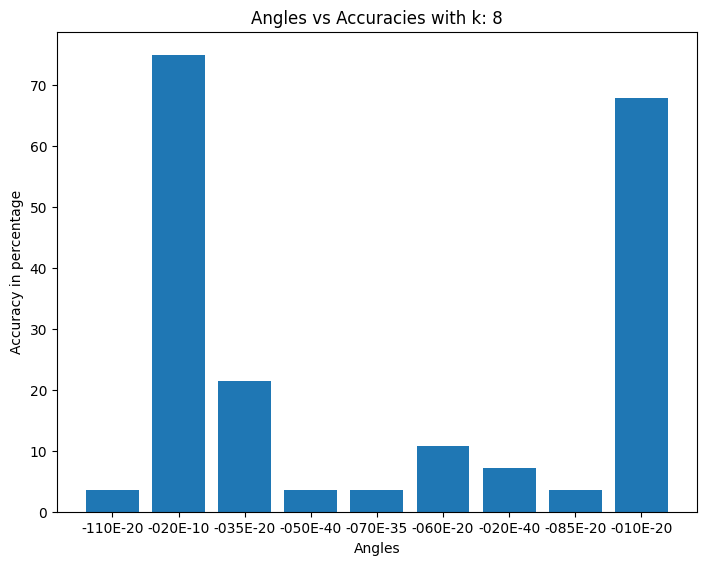

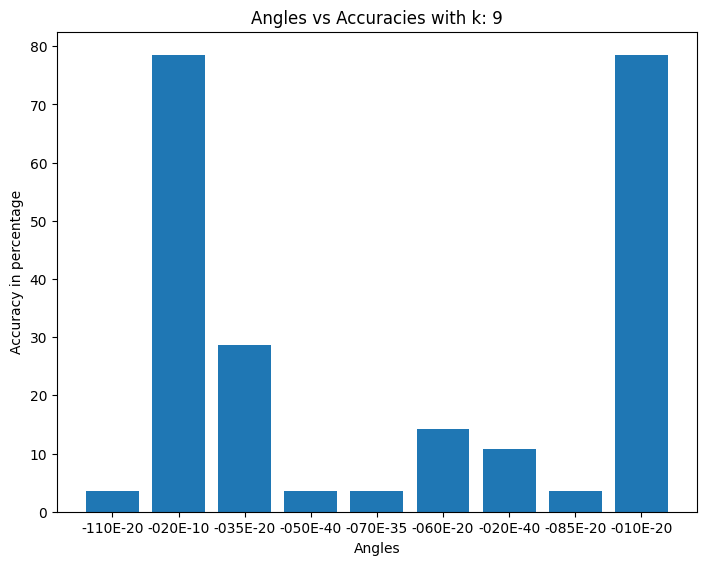

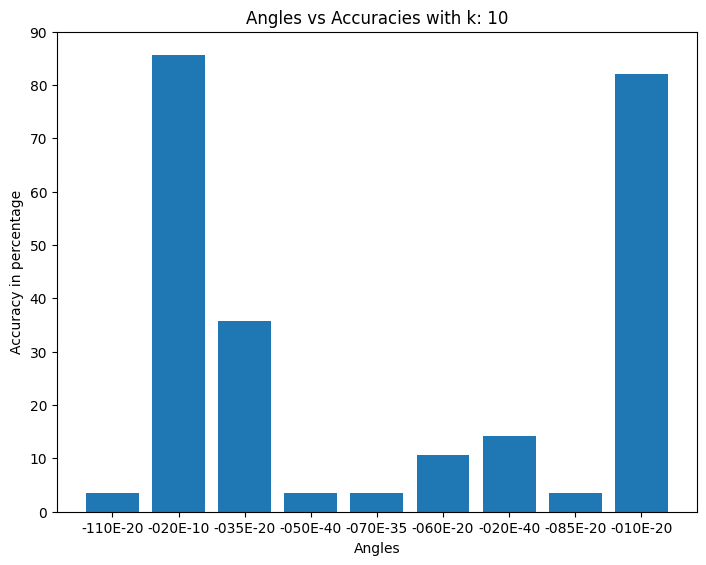

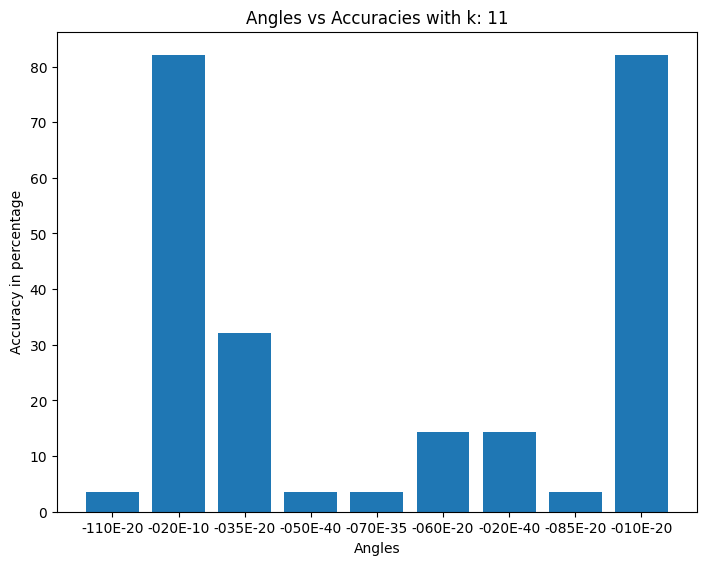

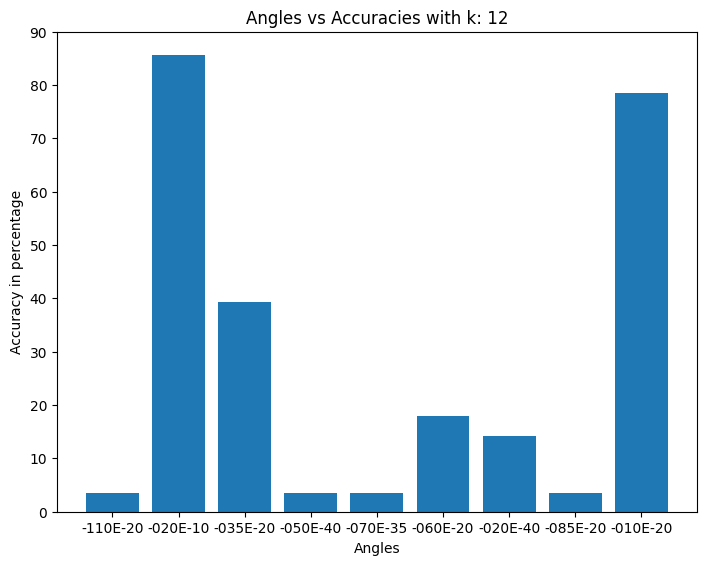

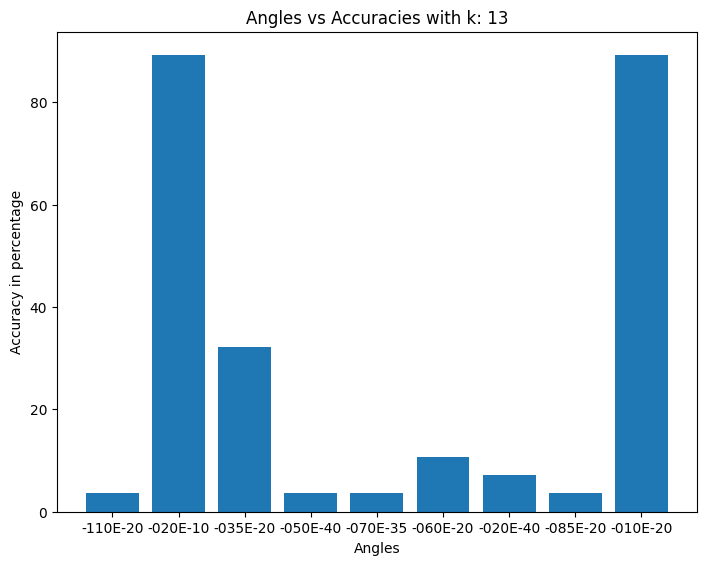

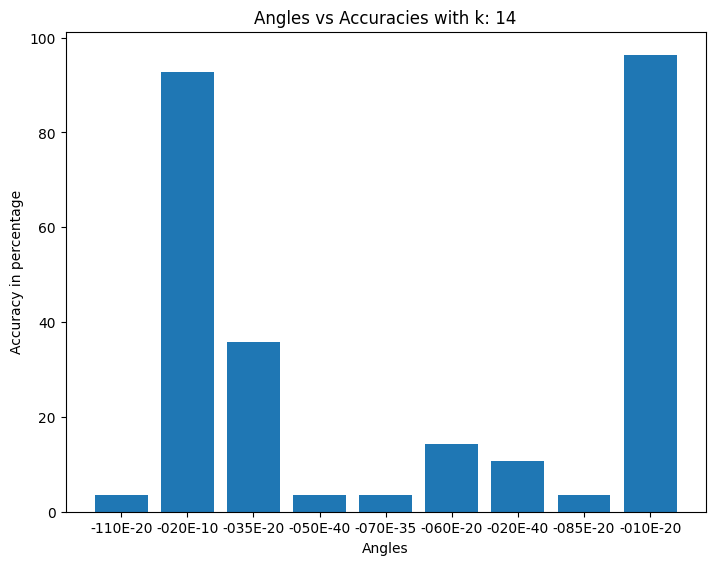

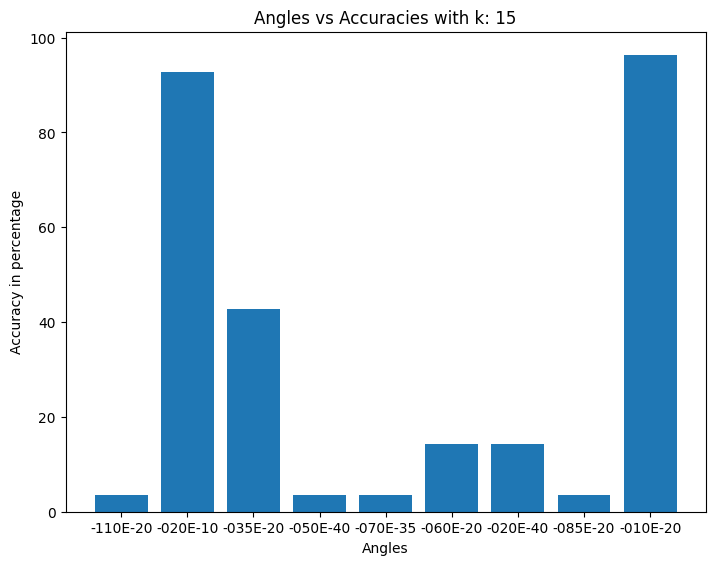

In [15]:
accuracies = []
ks = list(range(1, 16))
for k in ks:
  mean_training_image, V_training_eigenvectors = myPCA(training_raw_pixels_images, k)
  training_projection = getProjection(training_raw_pixels_images, V_training_eigenvectors, mean_training_image, k)

  model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
  model.fit(training_projection, training_labels)

  accuracies = []
  for angle in angles:
    raw_pixel_images = testing_raw_pixel_images_dictionary[angle]
    testing_labels = pathnames_dictionary_labels[angle]

    testing_projection = getProjection(raw_pixel_images, V_training_eigenvectors, mean_training_image, k)

    accuracies.append(model.score(testing_projection, testing_labels) * 100)

  # Plot
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(angles, accuracies)
  plt.title(f'Angles vs Accuracies with k: {k}')
  plt.xlabel("Angles")
  plt.ylabel("Accuracy in percentage")
  plt.show()
